In [ ]:
project：Sentiment Analysis of Public Opinion on Trump’s 2025 China Tariff Policy Based on "X"
Instructions：The data of Twitter comments from January to May obtained through api were analyzed.
    
To analyze the emotional reaction of the public to tariffs on China at different stages:
1.Data cleaning
2.Generation time feature(Three phases: January-March, April, and May)
3.Exploratory Data Analysis
4.The sentiment score is calculated using vader
5.The number of emotions is counted by stage based on the vader score
6.Create word clouds grouped by overall sentiment
7.Analysis of positive and negative emotional word cloud maps in different stages (January-March, April, and May)
8.The cloud images of positive, negative and neutral emotional words in different stages (January to March, April and May) 
and the top 15 high-frequency words were analyzed
9.pie chart of statistical emotion label distribution
10.Line chart of sentiment trends during the policy phase

Extended analysis of emotion classification model based on VADER pseudo-label:
1.Balanced datasets
2.
a)Enhance text preprocessing,
b)divide training set and test set
c)Create the feature extractor
d)Model selection and optimization (Logistic Regression,SVM,Random Forest,Gradient Boosting),
Define a better model and parameter grid, and use hierarchical k-fold cross-validation
e)Model Comparison and visualization
f)Best model selection and saving
The ensemble model performs better and is saved as 'best_ensemble_model.pkl'.


In [1]:
!pip install vaderSentiment
from wordcloud import WordCloud

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#1.Data cleaning
a)Remove duplicate tweets
b)Define cleaning function：Delete url, @ mention, hashtag, punctuation, numbers, lowercase and remove spaces.

In [2]:
#数据清洗#
import pandas as pd
import re

# 读取数据文件
df = pd.read_csv('ALLTwitter1.csv')
df = df[df["lang"] == "en"].copy()

# 步骤 2：去除重复推文（同文本同时间被视为重复）
df = df.drop_duplicates(subset=["full_text", "created_at"])

# 步骤 3：定义清洗函数
def clean_text(text):
    text = re.sub(r"http\S+|www\.\S+", "", text)   # 删除URL
    text = re.sub(r"@\w+", "", text)               # 删除@提及
    text = re.sub(r"#\w+", "", text)               # 删除hashtag
    text = re.sub(r"[^\w\s]", "", text)            # 删除标点符号
    text = re.sub(r"\d+", "", text)                # 删除数字
    text = text.lower().strip()                    # 小写化并去空格
    return text

# 步骤 4：应用清洗函数
df["clean_text"] = df["full_text"].astype(str).apply(clean_text)

# 可选：显示前几行结果检查
print(df[["created_at", "full_text", "clean_text"]].head())


                       created_at  \
0  Thu Jan 30 23:59:19 +0000 2025   
1  Thu Jan 30 23:58:26 +0000 2025   
2  Thu Jan 30 23:48:51 +0000 2025   
3  Thu Jan 30 23:48:41 +0000 2025   
4  Thu Jan 30 23:48:25 +0000 2025   

                                           full_text  \
0  @unusual_whales Threat? He literally did this ...   
1  Trump's 25% tariff on Canada and Mexico; a hig...   
2  Trump imposes 25% tariffs on Canada and Mexico...   
3  Trump imposes 25% tariffs on Canada and Mexico...   
4  @CanadaFreedom0 This is why Trump is tariff fo...   

                                          clean_text  
0  threat he literally did this in  people wake u...  
1  trumps  tariff on canada and mexico a higher o...  
2  trump imposes  tariffs on canada and mexico fr...  
3  trump imposes  tariffs on canada and mexico fr...  
4  this is why trump is tariff focused  mexico  t...  


In [3]:
print("Total tweets after cleaning:", len(df))


Total tweets after cleaning: 16984


In [ ]:
#2.Generation time feature；Three phases: January-March, April, and May
#a)Cast created_at to datetime type
#b)Filter out the rows that failed the conversion.
#c)Add month, policy phase fields

In [4]:
#生成时间特征#
# 强制转换 created_at 为 datetime 类型，指定格式更安全
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

# 过滤掉转换失败的行（即created_at为空的）
df = df[df['created_at'].notna()].copy()

# 添加月份字段
df['month'] = df['created_at'].dt.to_period('M').astype(str)

# 添加政策阶段字段
def get_policy_period(date):
    if date < pd.to_datetime("2025-04-01", utc=True):
        return "Jan–Mar"
    elif date < pd.to_datetime("2025-05-01", utc=True):
        return "April"
    else:
        return "May"

df['policy_period'] = df['created_at'].apply(get_policy_period)

# 检查
print(df[['created_at', 'month', 'policy_period']].head())



C:\Users\holy\AppData\Local\Temp\ipykernel_22580\73087119.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['created_at'].dt.to_period('M').astype(str)


                 created_at    month policy_period
0 2025-01-30 23:59:19+00:00  2025-01       Jan–Mar
1 2025-01-30 23:58:26+00:00  2025-01       Jan–Mar
2 2025-01-30 23:48:51+00:00  2025-01       Jan–Mar
3 2025-01-30 23:48:41+00:00  2025-01       Jan–Mar
4 2025-01-30 23:48:25+00:00  2025-01       Jan–Mar


In [ ]:
3.Exploratory Data Analysis（EDA）
a)Tweet length (in characters) analysis
b)Tweet word count
c)Distribution of tweet time
d)Creating overall words


C:\Users\holy\AppData\Local\Temp\ipykernel_22580\713126700.py:32: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['created_at'].dt.to_period('M')  # 提取年月（Period 类型）


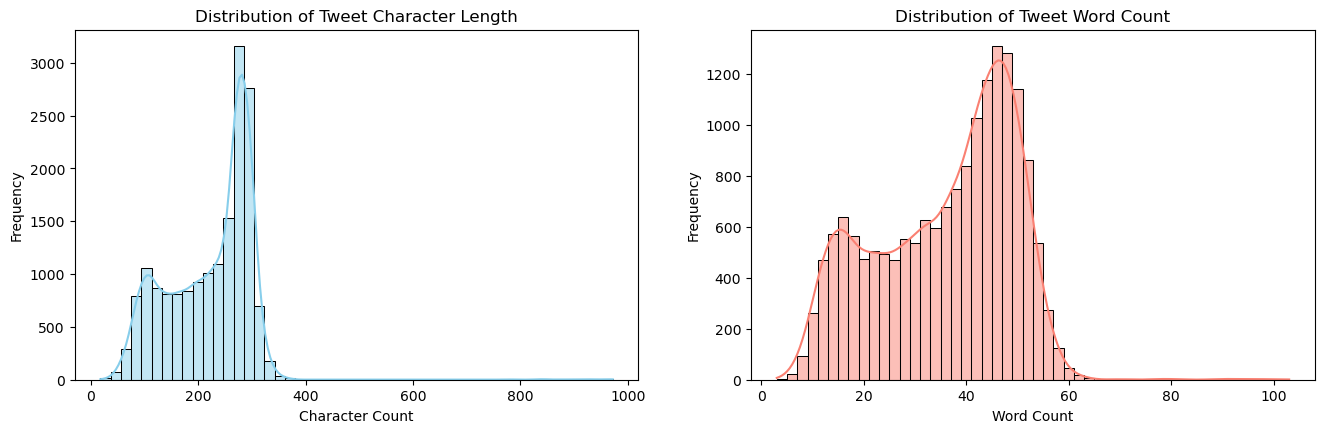

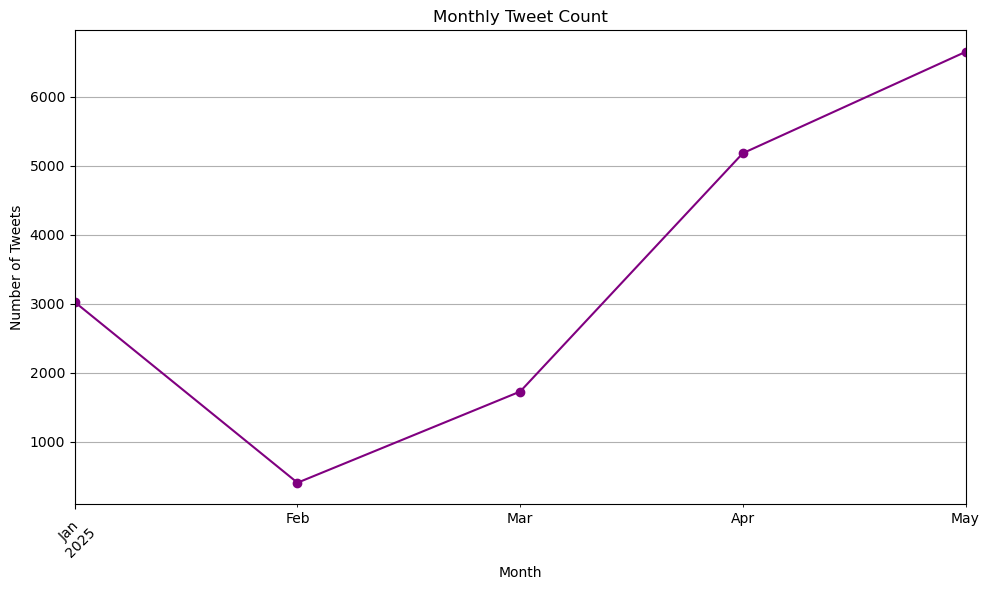

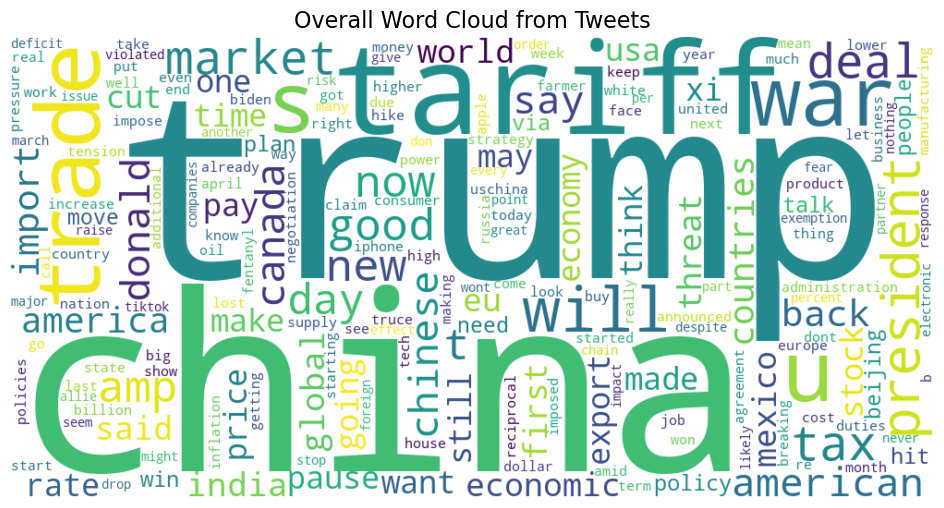

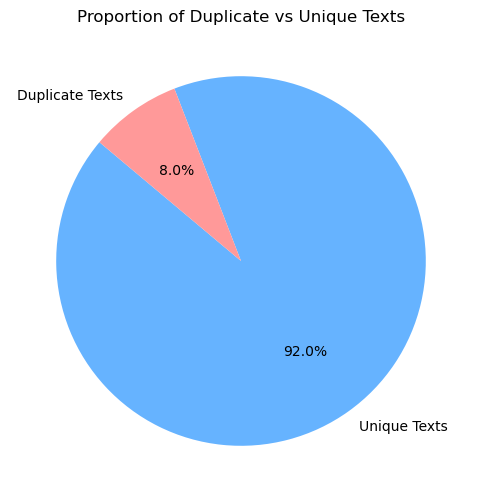

In [5]:
#EDA初步数据分析
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 推文长度（字符数）分析
df['char_count'] = df['full_text'].astype(str).apply(len)

# 2. 推文词数统计
df['word_count'] = df['full_text'].astype(str).apply(lambda x: len(x.split()))

# 3. 推文时间分布
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# 4. 可视化
plt.figure(figsize=(16, 10))

# ----------------- 1. 字符长度分布 -----------------
plt.subplot(2, 2, 1)
sns.histplot(df['char_count'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tweet Character Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

# ----------------- 2. 词数分布 -----------------
plt.subplot(2, 2, 2)
sns.histplot(df['word_count'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Tweet Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# 按月划分统计推文数量
df['month'] = df['created_at'].dt.to_period('M')  # 提取年月（Period 类型）
tweets_per_month = df['month'].value_counts().sort_index()

# 将 Period 类型转为 Timestamp 用于绘图
tweets_per_month.index = tweets_per_month.index.to_timestamp()

# 画图
plt.figure(figsize=(10, 6))
tweets_per_month.plot(kind='line', marker='o', color='purple')
plt.title('Monthly Tweet Count')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 合并所有文本为一段字符串
text = ' '.join(df['clean_text'].dropna().astype(str).tolist())

# 创建词云
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=200,
    collocations=False
).generate(text)

# 可视化展示
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Overall Word Cloud from Tweets", fontsize=16)
plt.show()
num_duplicates = df.duplicated(subset='clean_text').sum()
num_unique = df.shape[0] - num_duplicates

plt.figure(figsize=(6,6))
plt.pie([num_unique, num_duplicates], labels=['Unique Texts', 'Duplicate Texts'],
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=140)
plt.title('Proportion of Duplicate vs Unique Texts')
plt.show()



In [1]:
#4.The sentiment score is calculated using vader
Neutral scores were the most frequent in the sentiment score distribution (many tweets had compound scores near 0), 
but in terms of classified tweets, negative tweets greatly outnumbered positive tweets (roughly 2:1).


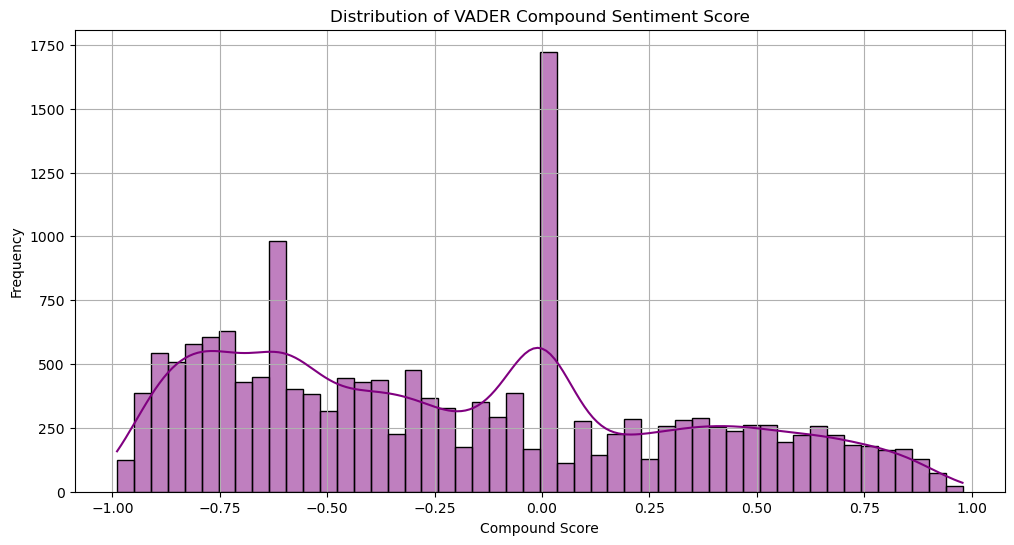

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# 初始化 VADER
analyzer = SentimentIntensityAnalyzer()

# 计算 compound 分数
df['vader_compound'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# 生成情绪标签
def get_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_compound'].apply(get_sentiment)

# 分布图：compound 得分分布
plt.figure(figsize=(12, 6))
sns.histplot(df['vader_compound'], bins=50, kde=True, color='purple')
plt.title("Distribution of VADER Compound Sentiment Score")
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [ ]:
5.The number of emotions is counted by stage based on the vader score

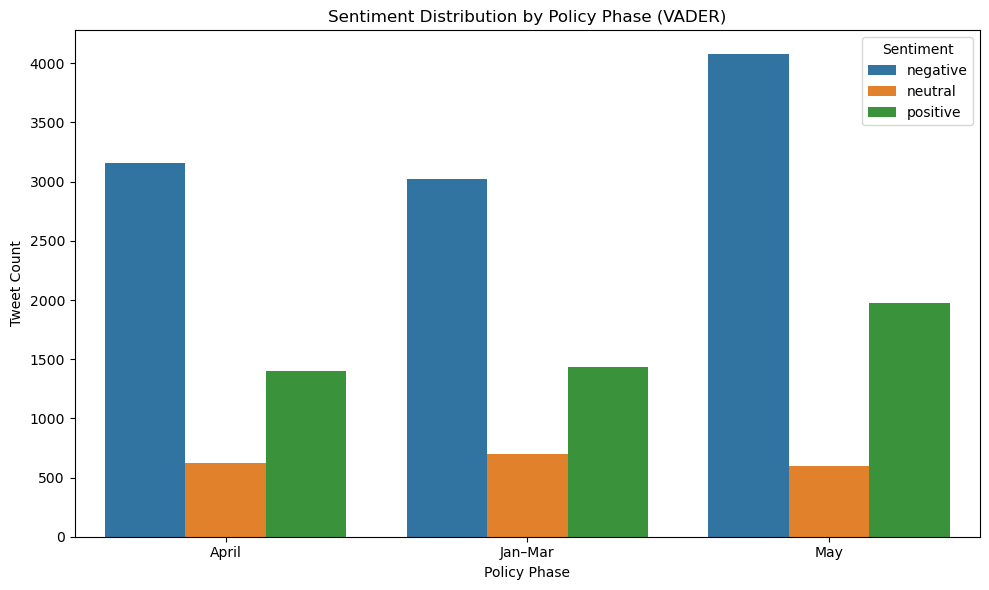

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 确保 policy_period 列存在（如 Jan-Mar, April, May）
# 如果没有，请先确保你已有以下函数生成过：
# def get_policy_period(date):
#     ...

# 按阶段统计情绪数量
phase_sentiment = df.groupby(['policy_period', 'vader_sentiment']).size().reset_index(name='count')

# 绘图
plt.figure(figsize=(10, 6))
sns.barplot(data=phase_sentiment, x='policy_period', y='count', hue='vader_sentiment')
plt.title('Sentiment Distribution by Policy Phase (VADER)')
plt.xlabel('Policy Phase')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [ ]:
6.Create word clouds grouped by overall sentiment
The overall positive tweets are accompanied by words such as "deal", "support" and "benefit", implying policy approval. 
Negative tweets often include words such as "war", "fear" and "lost", reflecting public concern and criticism.


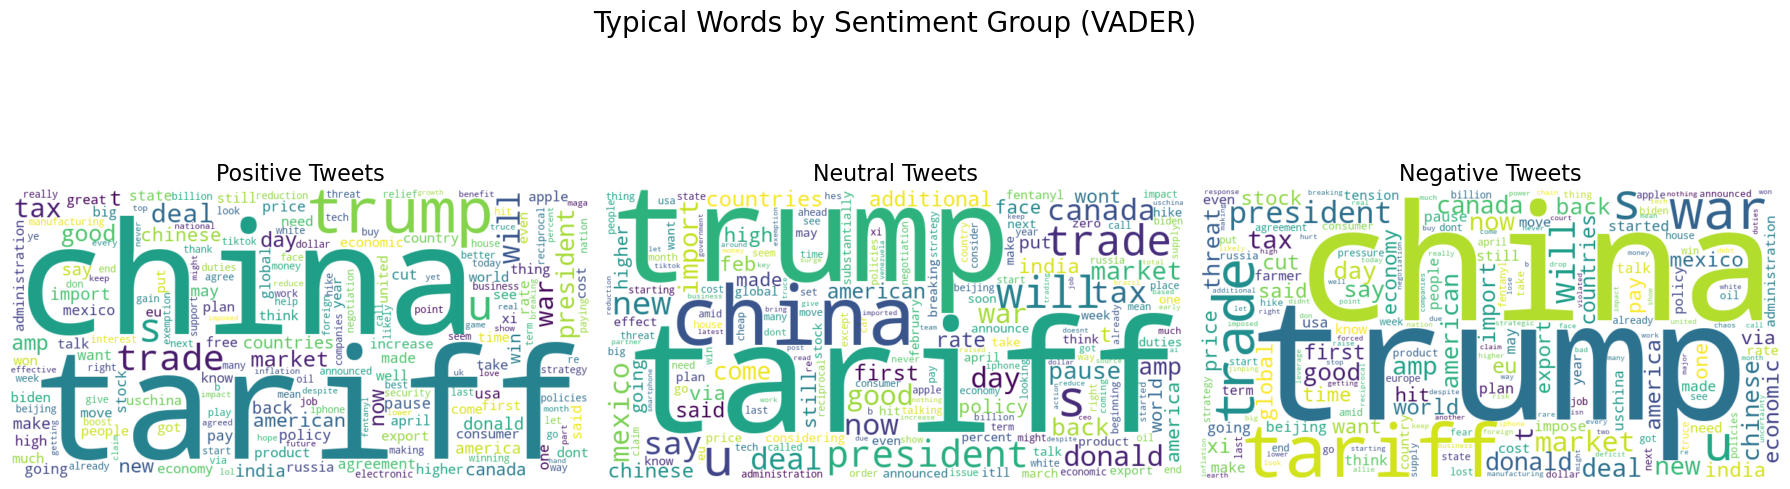

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 创建按情绪分组的词云图
sentiments = ['positive', 'neutral', 'negative']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    text = ' '.join(df[df['vader_sentiment'] == sentiment]['clean_text'].astype(str).tolist())
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200,
        collocations=False
    ).generate(text)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f'{sentiment.capitalize()} Tweets', fontsize=16)

plt.suptitle("Typical Words by Sentiment Group (VADER)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
7.Analysis of positive and negative emotional word cloud maps in different stages (January-March, April, and May)

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# 获取 compound 分数
df['vader_compound'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# 打标签
def get_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# 应用打标签函数
df['vader_sentiment'] = df['vader_compound'].apply(get_sentiment)

# ✅ ✅ ✅ 不再筛选，只保留全部三类标签（positive / negative / neutral）

# 保存为 CSV 文件
df.to_csv("vader_phase_sentiment.csv", index=False)


In [11]:
print(df['vader_sentiment'].value_counts())


vader_sentiment
negative    10255
positive     4816
neutral      1913
Name: count, dtype: int64


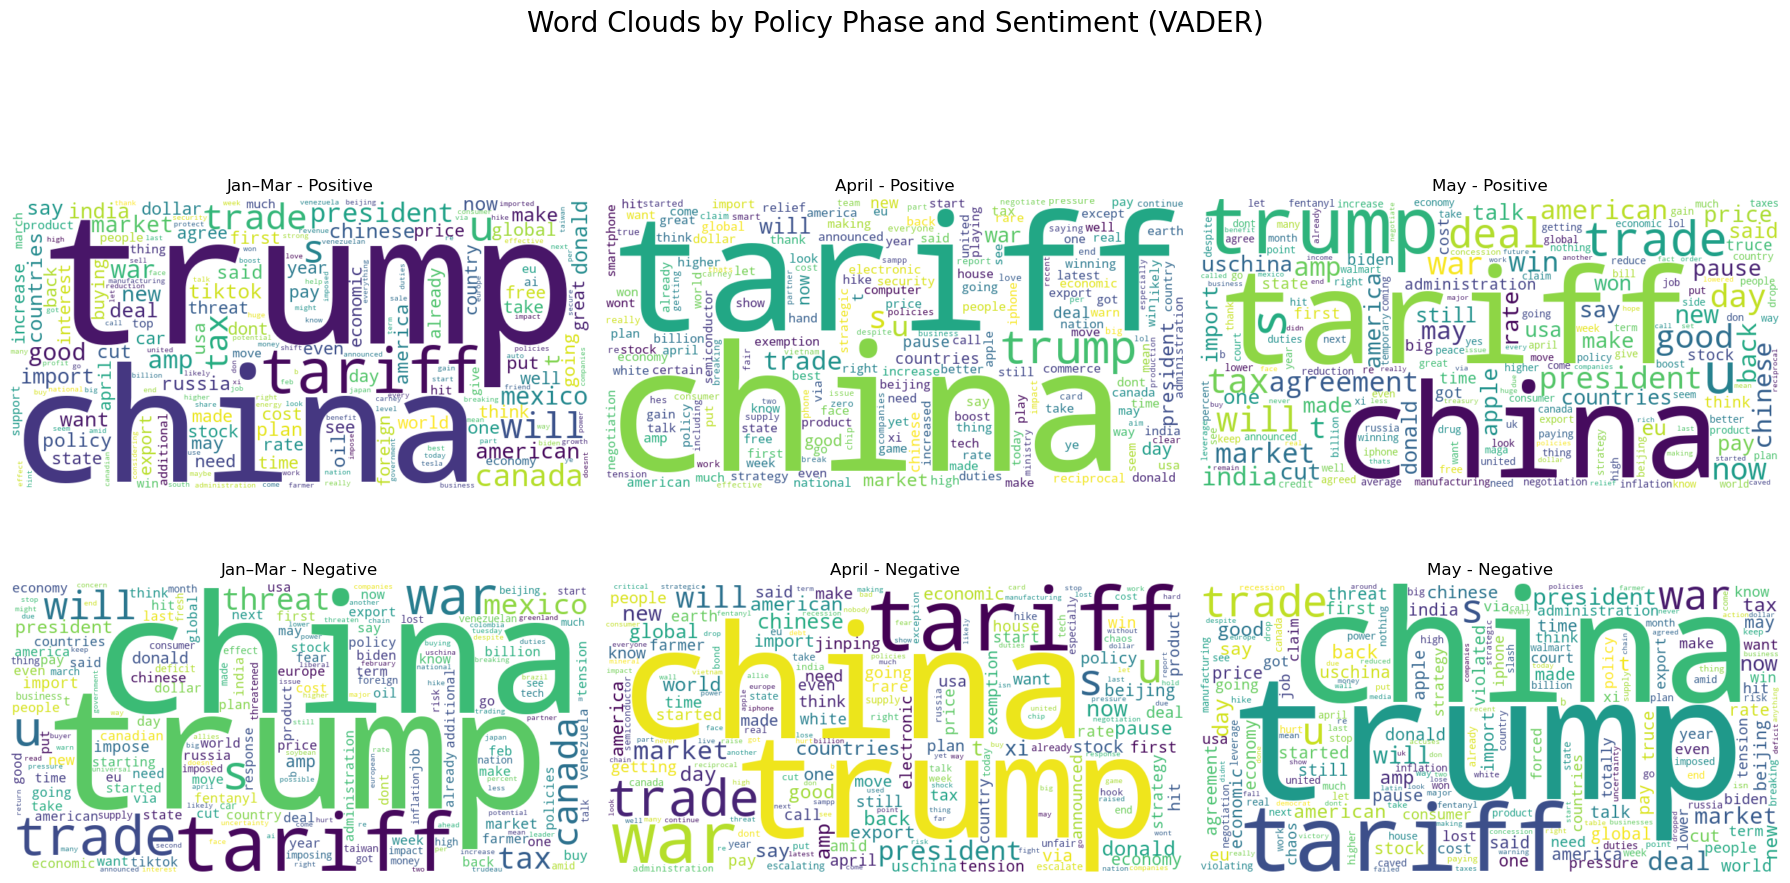

In [12]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# 保留正负情绪
#df = df[df['vader_sentiment'].isin(['positive', 'negative'])]#

# 三个阶段 + 两种情绪组合
periods = ['Jan–Mar', 'April', 'May']
top_words = []

# 生成词云图
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2行3列图像

for col, period in enumerate(periods):
    for row, sentiment in enumerate(['positive', 'negative']):
        subset = df[(df['policy_period'] == period) & (df['vader_sentiment'] == sentiment)]
        text = ' '.join(subset['clean_text'].dropna().astype(str).tolist())

        # Wordcloud
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              max_words=200, collocations=False).generate(text)
        axs[row][col].imshow(wordcloud, interpolation='bilinear')
        axs[row][col].axis('off')
        axs[row][col].set_title(f"{period} - {sentiment.capitalize()}")

        # Top 15 keywords
        if text.strip():
            vectorizer = CountVectorizer(stop_words='english', max_features=1000)
            X = vectorizer.fit_transform([text])
            word_freq = X.toarray().sum(axis=0)
            words = vectorizer.get_feature_names_out()
            freq_df = pd.DataFrame({'word': words, 'count': word_freq})
            freq_df = freq_df.sort_values(by='count', ascending=False).head(15)
            freq_df['policy_period'] = period
            freq_df['vader_sentiment'] = sentiment
            top_words.append(freq_df)

plt.suptitle("Word Clouds by Policy Phase and Sentiment (VADER)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 合并关键词表格（如果你需要查看或导出）
top_keywords_df = pd.concat(top_words, ignore_index=True)

# 可选：导出结果
top_keywords_df.to_csv("top15_keywords_by_phase_sentiment.csv", index=False)


In [ ]:
8.The cloud images of positive, negative and neutral emotional words in different stages (January to March, April and May)
and the top 15 high-frequency words were analyzed

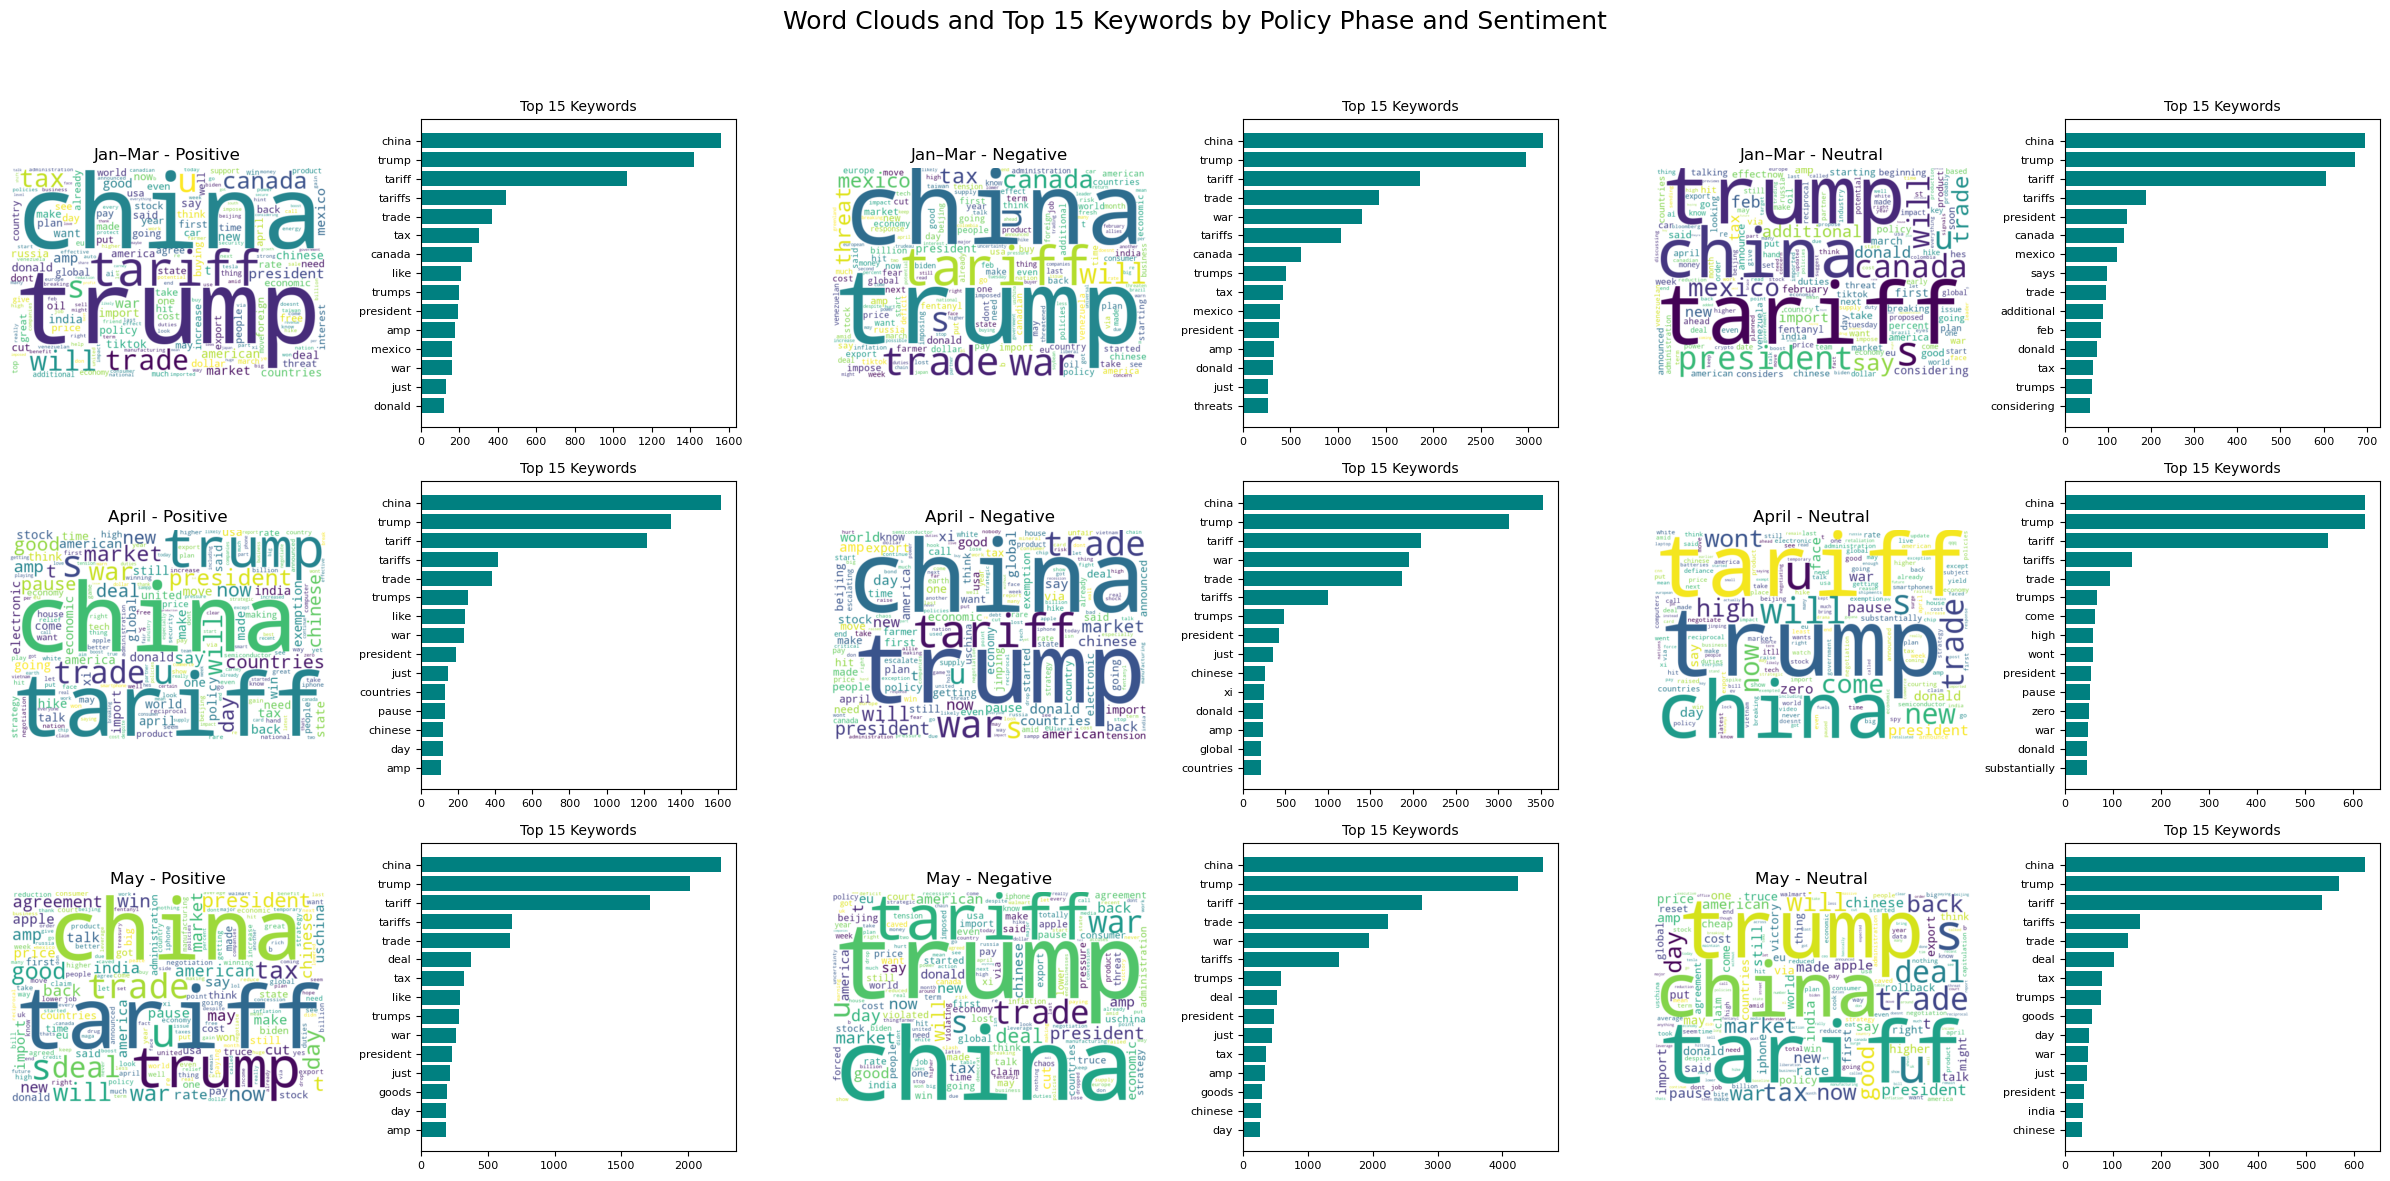

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# 设置阶段和情绪
periods = ['Jan–Mar', 'April', 'May']
sentiments = ['positive', 'negative', 'neutral']
top_words = []

# 设置图像布局：每组阶段-情绪组合占 2 列（词云+柱状图），共 3×3 行列组合
fig, axs = plt.subplots(3, 6, figsize=(24, 12))  # 3 行阶段 × (3情绪×2列)

for row, period in enumerate(periods):
    for col, sentiment in enumerate(sentiments):
        subset = df[(df['policy_period'] == period) & (df['vader_sentiment'] == sentiment)]
        text = ' '.join(subset['clean_text'].dropna().astype(str).tolist())

        # 子图索引：左词云图，右柱状图
        ax_wc = axs[row][col * 2]
        ax_bar = axs[row][col * 2 + 1]

        if text.strip():
            # WordCloud
            wordcloud = WordCloud(width=600, height=400, background_color='white',
                                  max_words=200, collocations=False).generate(text)
            ax_wc.imshow(wordcloud, interpolation='bilinear')
            ax_wc.axis('off')
            ax_wc.set_title(f"{period} - {sentiment.capitalize()}", fontsize=12)

            # Top 15 关键词条形图
            vectorizer = CountVectorizer(stop_words='english', max_features=1000)
            X = vectorizer.fit_transform([text])
            word_freq = X.toarray().sum(axis=0)
            words = vectorizer.get_feature_names_out()
            freq_df = pd.DataFrame({'word': words, 'count': word_freq})
            freq_df = freq_df.sort_values(by='count', ascending=False).head(15)

            # 添加元信息
            freq_df['policy_period'] = period
            freq_df['vader_sentiment'] = sentiment
            top_words.append(freq_df)

            # 柱状图
            ax_bar.barh(freq_df['word'], freq_df['count'], color='teal')
            ax_bar.set_title("Top 15 Keywords", fontsize=10)
            ax_bar.invert_yaxis()
            ax_bar.tick_params(labelsize=8)
        else:
            ax_wc.axis('off')
            ax_bar.axis('off')

plt.suptitle("Word Clouds and Top 15 Keywords by Policy Phase and Sentiment", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 合并关键词表格并导出
top_keywords_df = pd.concat(top_words, ignore_index=True)
top_keywords_df.to_csv("top15_keywords_by_phase_sentiment.csv", index=False)



In [ ]:
9.Pie chart of statistical emotion label distribution

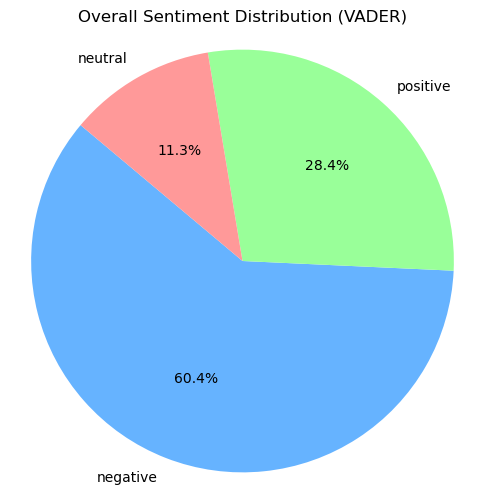

In [14]:
import matplotlib.pyplot as plt

# 统计情绪标签分布
sentiment_counts = df['vader_sentiment'].value_counts()

# 绘制饼状图
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#66b3ff', '#99ff99', '#ff9999']  # 可自定义颜色顺序
)
plt.title('Overall Sentiment Distribution (VADER)')
plt.axis('equal')  # 使饼图为圆形
plt.show()


In [ ]:
10.Line chart of sentiment trends during the policy phase

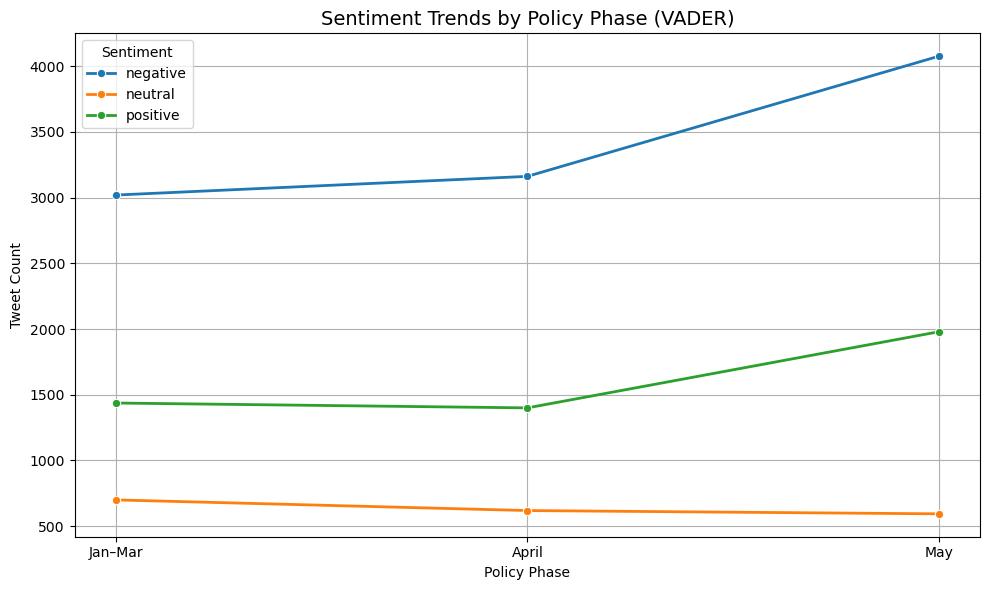

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. 加载 CSV 数据 ===
df = pd.read_csv("vader_phase_sentiment.csv")  # 请确认文件路径正确

# === 2. 预处理，仅保留所需列并去除缺失 ===
df = df[['policy_period', 'vader_sentiment']].dropna()

# === 3. 统计每阶段每类情绪推文数量 ===
line_df = df.groupby(['policy_period', 'vader_sentiment']).size().reset_index(name='count')

# === 4. 确保阶段顺序一致（手动指定）===
phase_order = ['Jan–Mar', 'April', 'May']
line_df['policy_period'] = pd.Categorical(line_df['policy_period'], categories=phase_order, ordered=True)
line_df = line_df.sort_values(by='policy_period')

# === 5. 绘制折线图 ===
plt.figure(figsize=(10, 6))
sns.lineplot(data=line_df, x='policy_period', y='count', hue='vader_sentiment', marker='o', linewidth=2)
plt.title('Sentiment Trends by Policy Phase (VADER)', fontsize=14)
plt.xlabel('Policy Phase')
plt.ylabel('Tweet Count')
plt.grid(True)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [ ]:
Extended analysis of emotion classification model based on VADER pseudo-label:
1.Balanced datasets

In [16]:
import pandas as pd
from sklearn.utils import resample

# 原始数据（未平衡）
df = pd.read_csv("vader_phase_sentiment.csv")  # 替换为你的数据路径

# 1. 获取原始类别分布
original_counts = df['vader_sentiment'].value_counts()
print("原始分布：\n", original_counts)

# 2. 确定下采样目标（以最小类的样本数为准）
target_size = original_counts.min()  # 这里是1913（neutral的数量）

# 3. 对每个类别下采样（从原始df中抽取，而非已平衡的df）
balanced_df = pd.concat([
    resample(df[df['vader_sentiment'] == 'negative'], 
             n_samples=target_size, random_state=42, replace=False),  # 不重复采样
    resample(df[df['vader_sentiment'] == 'positive'], 
             n_samples=target_size, random_state=42, replace=False),
    resample(df[df['vader_sentiment'] == 'neutral'], 
             n_samples=target_size, random_state=42, replace=False)
])

# 4. 验证平衡结果
balanced_counts = balanced_df['vader_sentiment'].value_counts()
print("\n平衡后分布：\n", balanced_counts)
if len(set(balanced_counts)) == 1:
    print("✅ 数据已平衡（三类数量均为", target_size, "）")
else:
    print("❌ 平衡失败，检查采样逻辑")

原始分布：
 vader_sentiment
negative    10255
positive     4816
neutral      1913
Name: count, dtype: int64

平衡后分布：
 vader_sentiment
negative    1913
positive    1913
neutral     1913
Name: count, dtype: int64
✅ 数据已平衡（三类数量均为 1913 ）


balanced_df 的列： ['conversation_id_str', 'created_at', 'favorite_count', 'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 'user_id_str', 'username', 'clean_text', 'month', 'policy_period', 'char_count', 'word_count', 'vader_compound', 'vader_sentiment']


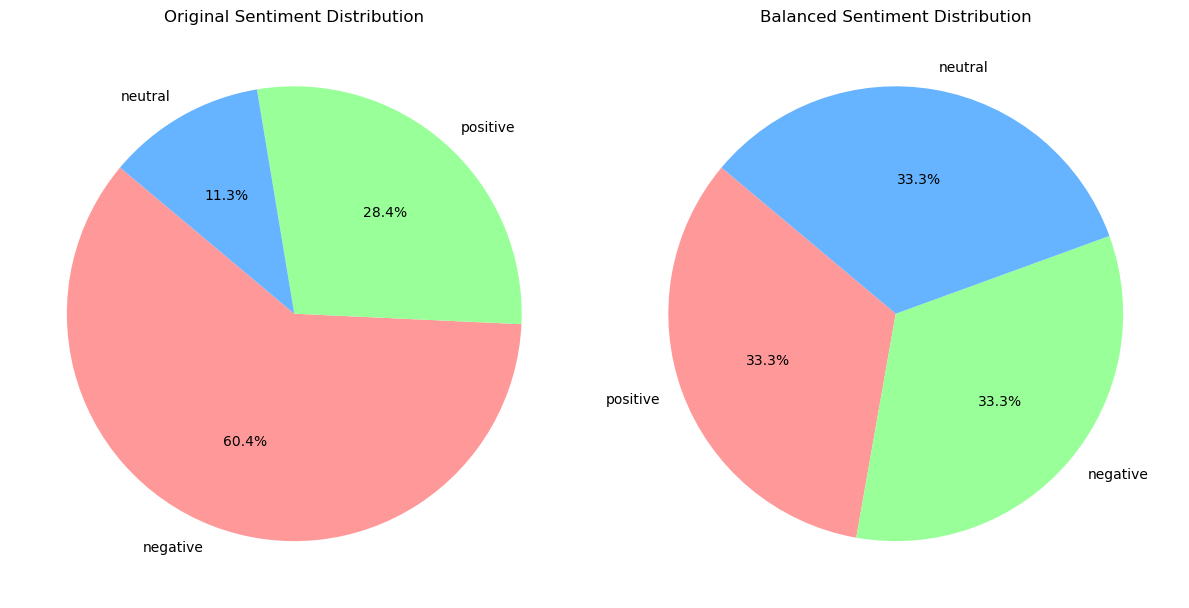

In [17]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt

# 1. 加载原始数据（包含 clean_text 列的完整数据）
df = pd.read_csv('vader_phase_sentiment.csv')  # 替换为实际文件路径

# === 原始数据集情绪分布 ===
original_counts = df['vader_sentiment'].value_counts()

# 设定目标样本数量（最小类 Neutral 的数量）
target_size = original_counts.min()

# 2. 修改下采样逻辑：确保保留所有列
balanced_df = pd.DataFrame()
for sentiment in ['positive', 'negative', 'neutral']:
    subset = df[df['vader_sentiment'] == sentiment]
    resampled = resample(subset, replace=False, n_samples=target_size, random_state=42)
    balanced_df = pd.concat([balanced_df, resampled])

# 现在检查 balanced_df 的列，应该包含 clean_text 了
print("balanced_df 的列：", balanced_df.columns.tolist())

# === 对比原始 vs 平衡后分布 ===
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 原始分布饼图
axes[0].pie(
    original_counts,
    labels=original_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ff9999', '#99ff99', '#66b3ff']
)
axes[0].set_title("Original Sentiment Distribution")

# 平衡分布饼图
balanced_counts = balanced_df['vader_sentiment'].value_counts()
axes[1].pie(
    balanced_counts,
    labels=balanced_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ff9999', '#99ff99', '#66b3ff']
)
axes[1].set_title("Balanced Sentiment Distribution")

plt.tight_layout()
plt.show()

# 后续就可以正常用 balanced_df['clean_text'] 做特征提取等操作了，比如接着写：
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(balanced_df['clean_text'])
# ...

In [18]:
import pandas as pd
from sklearn.utils import resample

# 原始数据（未平衡）
df = pd.read_csv("vader_phase_sentiment.csv")  # 替换为你的数据路径

# 1. 获取原始类别分布
original_counts = df['vader_sentiment'].value_counts()
print("原始分布：\n", original_counts)

# 2. 确定下采样目标（以最小类的样本数为准）
target_size = original_counts.min()  

# 3. 对每个类别下采样（从原始 df 中抽取，而非已平衡的 df）
balanced_df = pd.concat([
    resample(df[df['vader_sentiment'] == 'negative'], 
             n_samples=target_size, random_state=42, replace=False),  
    resample(df[df['vader_sentiment'] == 'positive'], 
             n_samples=target_size, random_state=42, replace=False),
    resample(df[df['vader_sentiment'] == 'neutral'], 
             n_samples=target_size, random_state=42, replace=False)
])

# 4. 验证平衡结果
balanced_counts = balanced_df['vader_sentiment'].value_counts()
print("\n平衡后分布：\n", balanced_counts)
if len(set(balanced_counts)) == 1:
    print("✅ 数据已平衡（三类数量均为", target_size, "）")
else:
    print("❌ 平衡失败，检查采样逻辑")

# 5. 保存平衡后的数据集到 CSV 文件
balanced_df.to_csv('balanced_vader_sentiment.csv', index=False)
print("平衡后的数据集已保存为 balanced_vader_sentiment.csv")

原始分布：
 vader_sentiment
negative    10255
positive     4816
neutral      1913
Name: count, dtype: int64

平衡后分布：
 vader_sentiment
negative    1913
positive    1913
neutral     1913
Name: count, dtype: int64
✅ 数据已平衡（三类数量均为 1913 ）
平衡后的数据集已保存为 balanced_vader_sentiment.csv


In [ ]:
Extended analysis of emotion classification model based on VADER pseudo-label:
2.
a)Enhance text preprocessing,
b)divide training set and test set
c)Create the feature extractor
d)Model selection and optimization (Logistic Regression,SVM,Random Forest,Gradient Boosting),
Define a better model and parameter grid, and use hierarchical k-fold cross-validation
e)Model Comparison and visualization
f)Best model selection and saving
The ensemble model performs better and is saved as 'best_ensemble_model.pkl'.


加载数据集...
平衡数据集信息:
总样本数: 5739
类别分布:
vader_sentiment
negative    1913
positive    1913
neutral     1913
Name: count, dtype: int64

增强文本预处理...

训练集大小: 4878
测试集大小: 861

特征工程...

模型训练与优化...

=== 优化 Logistic Regression ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Logistic Regression 最佳参数: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Logistic Regression 测试集准确率: 0.7131
Logistic Regression 测试集F1值: 0.7132
              precision    recall  f1-score   support

    negative       0.75      0.71      0.73       287
     neutral       0.68      0.74      0.71       287
    positive       0.71      0.69      0.70       287

    accuracy                           0.71       861
   macro avg       0.71      0.71      0.71       861
weighted avg       0.71      0.71      0.71       861


=== 优化 SVM ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM 最佳参数: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
SVM 测试集准确率: 0.7213
SVM 测试集F1值: 0.

D:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}

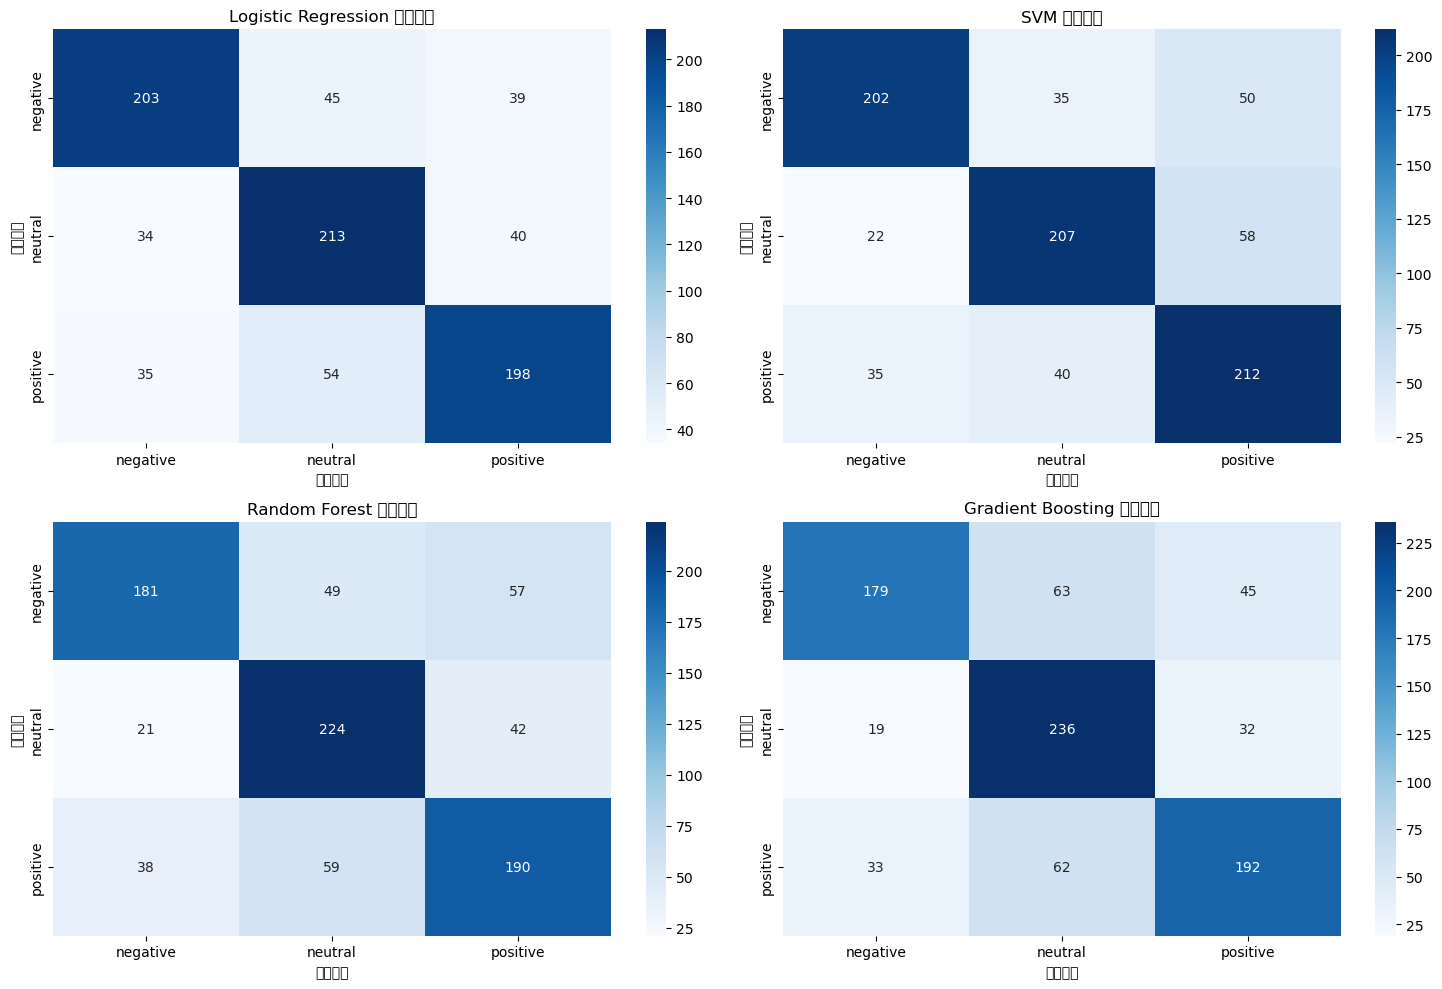


最佳模型: SVM (准确率: 0.7213)
最佳模型已保存为 'best_sentiment_model.pkl'

尝试集成模型...
集成模型准确率: 0.7305
              precision    recall  f1-score   support

    negative       0.76      0.71      0.74       287
     neutral       0.71      0.76      0.74       287
    positive       0.72      0.72      0.72       287

    accuracy                           0.73       861
   macro avg       0.73      0.73      0.73       861
weighted avg       0.73      0.73      0.73       861

集成模型表现更佳，已保存为 'best_ensemble_model.pkl'

优化完成!


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB  # 比MultinomialNB更适合不平衡数据
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import joblib
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# 下载必要的NLTK资源
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# 1. 加载平衡后的数据集
print("加载数据集...")
balanced_df = pd.read_csv('balanced_vader_sentiment.csv')
print("平衡数据集信息:")
print(f"总样本数: {len(balanced_df)}")
print(f"类别分布:\n{balanced_df['vader_sentiment'].value_counts()}")

# 2. 增强数据预处理
print("\n增强文本预处理...")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def enhanced_text_preprocessing(text):
    """增强的文本预处理函数"""
    if not isinstance(text, str):
        return ""
    
    # 基本清理
    text = re.sub(r'http\S+|@\w+|#\w+|\d+', '', text)  # 移除URL、提及、标签和数字
    text = re.sub(r'[^\w\s]', ' ', text)  # 移除非字母数字字符（保留空格）
    
    # 保留情感相关的标点（如! ?）
    text = re.sub(r'([!?])', r' \1 ', text)  # 给标点加空格
    
    # 词形还原和过滤
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token not in stop_words and len(token) > 1]
    
    return " ".join(tokens)

# 应用预处理
balanced_df['processed_text'] = balanced_df['clean_text'].apply(enhanced_text_preprocessing)

# 3. 划分训练集和测试集
X = balanced_df['processed_text']
y = balanced_df['vader_sentiment']

# 使用分层抽样保持类别比例
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y  # 减少测试集比例，增加训练数据
)

print(f"\n训练集大小: {len(X_train)}")
print(f"测试集大小: {len(X_test)}")

# 4. 增强特征工程
print("\n特征工程...")

# 创建特征提取器（TF-IDF + 词袋）
tfidf = TfidfVectorizer(
    max_features=8000,   # 增加特征数量
    ngram_range=(1, 3),  # 包含一元、二元和三元语法
    min_df=3,            # 忽略低频词
    max_df=0.7,          # 忽略高频词
    sublinear_tf=True,   # 使用对数TF
    stop_words='english'
)

# 特征降维（可选）
svd = TruncatedSVD(n_components=1000, random_state=42)

# 5. 模型选择与优化
print("\n模型训练与优化...")

# 定义更优的模型和参数网格
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__solver': ['saga', 'liblinear'],
            'clf__penalty': ['l1', 'l2']
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42, class_weight='balanced'),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample'),
        'params': {
            'clf__max_depth': [None, 30, 50],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(n_estimators=200, random_state=42),
        'params': {
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5],
            'clf__subsample': [0.8, 1.0]
        }
    }
}

# 存储评估结果
results = {}
best_models = {}

# 使用分层K折交叉验证
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model_info in models.items():
    print(f"\n=== 优化 {name} ===")
    
    # 创建管道
    pipeline = Pipeline([
        ('tfidf', tfidf),
        # ('svd', svd),  # 如果需要降维可以启用
        ('clf', model_info['model'])
    ])
    
    # 网格搜索
    grid_search = GridSearchCV(
        pipeline,
        model_info['params'],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,  # 使用所有核心
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # 获取最佳模型
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # 评估测试集
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} 最佳参数: {best_params}")
    print(f"{name} 测试集准确率: {acc:.4f}")
    print(f"{name} 测试集F1值: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    
    # 保存结果
    results[name] = {
        'model': best_model,
        'accuracy': acc,
        'f1': f1,
        'params': best_params,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }
    best_models[name] = best_model

# 6. 模型比较与可视化
# 创建比较表格
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'F1 Score': [res['f1'] for res in results.values()]
}).sort_values('Accuracy', ascending=False)

print("\n模型性能比较:")
print(model_comparison)

# 可视化混淆矩阵
plt.figure(figsize=(15, 10))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, res['model'].predict(X_test))
    classes = sorted(y.unique())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{name} 混淆矩阵')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# 7. 最佳模型选择与保存
best_model_name = model_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print(f"\n最佳模型: {best_model_name} (准确率: {best_accuracy:.4f})")

# 保存最佳模型
joblib.dump(best_model, 'best_sentiment_model.pkl')
print("最佳模型已保存为 'best_sentiment_model.pkl'")

# 8. 集成模型（可选）
print("\n尝试集成模型...")
from sklearn.ensemble import VotingClassifier

# 选择前2-3个最佳模型进行集成
top_models = model_comparison.head(3)['Model'].tolist()
estimators = [(name, best_models[name]) for name in top_models]

voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',  # 使用概率投票
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
acc_voting = accuracy_score(y_test, y_pred_voting)

print(f"集成模型准确率: {acc_voting:.4f}")
print(classification_report(y_test, y_pred_voting))

# 如果集成模型表现更好，则保存它
if acc_voting > best_accuracy:
    joblib.dump(voting_clf, 'best_ensemble_model.pkl')
    print("集成模型表现更佳，已保存为 'best_ensemble_model.pkl'")

print("\n优化完成!")